In [ ]:
!pip install transformers datasets sentencepiece

### Importing the required libarires

In [1]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from transformers import (AdamW,T5ForConditionalGeneration,T5Tokenizer,get_linear_schedule_with_warmup)

### Loading the dataset¶

In [2]:
dataset = load_dataset('glue', 'wnli')
print(dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Found cached dataset glue (C:/Users/NIT/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})


device(type='cuda')

### Loading the tokenizer and pre-trained model

In [3]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model.to(device)
print('Loaded Model')

C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\transformers\models\t5\tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Loaded Model


### Forming the train, validaton and test loaders

In [4]:
def getDataLoader(input):
    inputs = ["wnli sentence1: " + doc1 + " sentence2: "+ doc2 for doc1, doc2 in zip(input['sentence1'], input['sentence2'])]
    tokenized_inputs = tokenizer(inputs, padding = True, truncation = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']
    
    targets = ['entailment' if label == 1 else 'not_entailment' for label in input['label']]
    tokenized_outputs = tokenizer(targets, padding = True, return_tensors="pt")
    target_ids = tokenized_outputs['input_ids']
    target_mask = tokenized_outputs['attention_mask']

    # Create a TensorDataset
    batch_size = 32
    data = TensorDataset(source_ids, source_mask, target_ids, target_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)

train_dataloader = getDataLoader(dataset['train'])
validation_dataloader = getDataLoader(dataset['validation'])
test_dataloader = getDataLoader(dataset['test'])

In [17]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-4,
    eps=1e-8,
)

num_epochs = 3
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine-tuning T5

In [18]:
from tqdm import tqdm
best_accuracy = 0
for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0
    for batch in tqdm(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        source_ids, source_mask, lm_labels, target_mask = batch
        lm_labels[lm_labels[:, :] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        outputs = model(
            input_ids=source_ids,
            attention_mask=source_mask,
            labels = lm_labels,
            decoder_attention_mask=target_mask
        )
        
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        scheduler.step()
    
    # Compute the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - loss: {avg_loss:.4f}')
        


    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in tqdm(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                  attention_mask=source_mask,
                                  max_length=10)

            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label=='entailment' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
            
    total_correct  = 0
    for i in range(len(predictions)):
        if predictions[i]==dataset['validation'][i]['label']:
            total_correct += 1

    accuracy = total_correct/len(dataset['validation'])
    print(f'Epoch {epoch+1}/{num_epochs} - validation accuracy: {accuracy:.4f}')
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        model.save_pretrained("t5-wnli")

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch 1/3 - loss: 0.1925


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 1/3 - validation accuracy: 0.5634


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.34it/s]


Epoch 2/3 - loss: 0.1370


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.45it/s]


Epoch 2/3 - validation accuracy: 0.5634


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]


Epoch 3/3 - loss: 0.1347


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.61it/s]

Epoch 3/3 - validation accuracy: 0.3662


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("PavanNeerudu/t5-finetuned-wnli")

model = AutoModelForSeq2SeqLM.from_pretrained("PavanNeerudu/t5-finetuned-wnli")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-wnli")
model.cuda()

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
model.push_to_hub("t5-finetuned-wnli")
tokenizer.push_to_hub("t5-finetuned-wnli")

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/PavanNeerudu/t5-finetuned-wnli/commit/fd7e612039e5b6f609446a0503e6c3a10416a975', commit_message='Upload tokenizer', commit_description='', oid='fd7e612039e5b6f609446a0503e6c3a10416a975', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("PavanNeerudu/t5-base-finetuned-wnli")

fineTunedModel = AutoModelForSeq2SeqLM.from_pretrained("PavanNeerudu/t5-base-finetuned-wnli")
fineTunedModel.cuda()
print('Loaded model and tokenizer')

C:\Users\NIT\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NIT\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loaded model and tokenizer


###  Obtaining hidden states averaged over all the tokens to get a single representation of 768 tokens

In [6]:
def getHiddenStates(currModel, dataloader):
    currModel.eval()
    totalHiddenStates = [0]*13
    flag = True
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            
            source_ids, source_mask, lm_labels, target_mask = batch
            outputs = currModel(input_ids=source_ids,
                            attention_mask=source_mask,
                            labels = lm_labels,
                            decoder_attention_mask=target_mask, 
                            output_hidden_states = True, 
                            return_dict=True)

            hidden_states = outputs.encoder_hidden_states
         
            if flag == True:
                for i in range(len(hidden_states)):
                    totalHiddenStates[i] = hidden_states[i].to("cpu").mean(dim = 1)
                flag = False
            else:
                for i in range(len(hidden_states)):
                    temp = hidden_states[i].to("cpu").mean(dim = 1)
                    totalHiddenStates[i] = torch.cat((totalHiddenStates[i], temp), 0)   
        return totalHiddenStates   


In [7]:
hiddenStates = getHiddenStates(model, test_dataloader)
preTrainedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(preTrainedHiddenStates, 'preTrainedHiddenStates_WNLI.pt')
print(preTrainedHiddenStates.shape)

hiddenStates = getHiddenStates(fineTunedModel, test_dataloader)
fineTunedHiddenStates = torch.stack(hiddenStates, dim = 0)
torch.save(fineTunedHiddenStates, 'fineTunedHiddenStates_WNLI.pt')
print(fineTunedHiddenStates.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.10s/it]


torch.Size([13, 146, 768])


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.56it/s]

torch.Size([13, 146, 768])


In [8]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [9]:
cka_matrix = torch.empty((13, 13))
for i in range(13):
    for j in range(13):
        X = preTrainedHiddenStates[i].to(device)
        Y = fineTunedHiddenStates[j].to(device)
        cka_matrix[i][j] = cuda_cka.linear_CKA(X, Y)
#torch.save(cka_matrix, 'ckaMatrix.pt')
cka_matrix = cka_matrix.numpy()

In [10]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

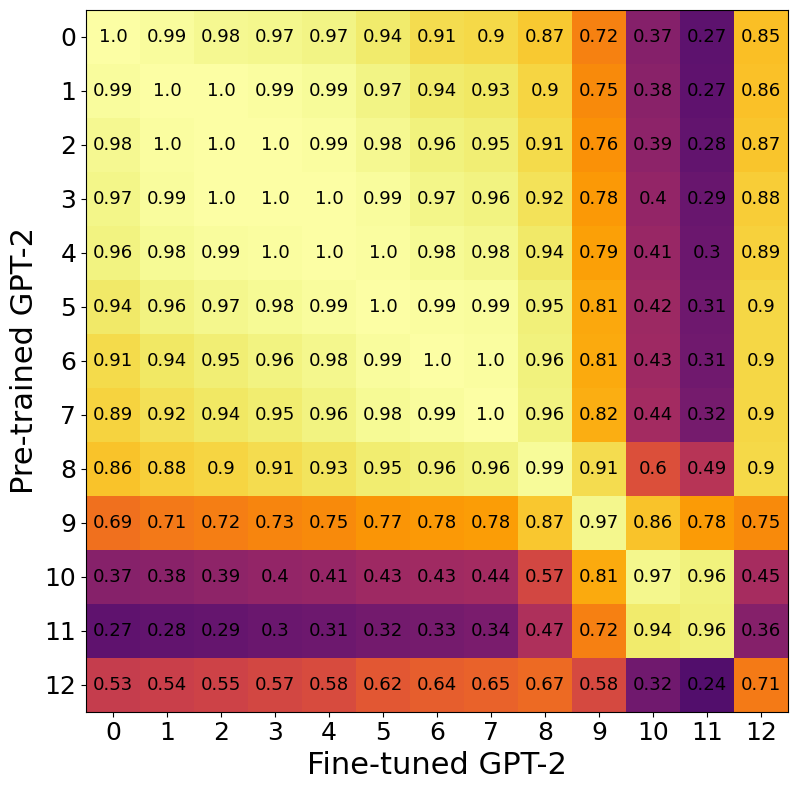

In [11]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cka_matrix, cmap="inferno", vmin=0.0, vmax=1.0)

plt.xticks(np.arange(0,13), fontsize = 18)
plt.yticks(np.arange(0,13), fontsize = 18)

cka_matrix = np.round(cka_matrix, 2)
for x in range(13):
    for y in range(13):
        plt.annotate(cka_matrix[x][y], xy=(y, x), horizontalalignment='center', verticalalignment='center', fontsize=13)

plt.ylabel('Pre-trained GPT-2', fontsize = 22)
plt.xlabel('Fine-tuned GPT-2', fontsize = 22)

#fig.colorbar(im)

plt.tight_layout()

#plt.show()

plt.savefig('WNLI_preTrained_fineTuned.pdf',  bbox_inches='tight')
plt.savefig('WNLI_preTrained_fineTuned.jpg',  bbox_inches='tight')

### Calculating STIR

In [12]:
preTrainedHiddenStates = torch.load('./preTrainedHiddenStates_WNLI.pt').to(device)
fineTunedHiddenStates  = torch.load('./fineTunedHiddenStates_WNLI.pt').to(device)
print(preTrainedHiddenStates.shape,fineTunedHiddenStates.shape)

torch.Size([13, 146, 768]) torch.Size([13, 146, 768])


In [13]:
distinm1 = []
distinm2 = []
for i in range(13):
    distinm1.append(torch.cdist(preTrainedHiddenStates[i], preTrainedHiddenStates[i]))
    distinm2.append(torch.cdist(fineTunedHiddenStates[i], fineTunedHiddenStates[i]))

In [14]:
for i in range(13):
    for j in range(distinm1[0].shape[0]):
        distinm1[i][j][j] = 100000.0
        distinm2[i][j][j] = 100000.0

In [15]:
num_rows = preTrainedHiddenStates.shape[1]
minDistIndForm1 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm1[i][j]))
    minDistIndForm1.append(temp)
    
minDistIndForm2 = []
for i in range(13):
    temp = []
    for j in range(num_rows):
        temp.append(torch.argmin(distinm2[i][j]))
    minDistIndForm2.append(temp)

In [16]:
from CKA import CKA, CudaCKA
cuda_cka = CudaCKA(device)

In [17]:
import random
def calculate(noOfSamples, noOfTimes):
    STIRm2m1 = []
    STIRm1m2 = []
    CKA = []
    for i in range(13):
        stirm2m1 = 0
        stirm1m2 = 0
        cka = 0
        for j in range(noOfTimes):
            num_list = random.sample(range(0, num_rows), noOfSamples)
            X = []
            X_ = []
            Y = []
            Y_ = []
            for k in range(len(num_list)):
                X.append(fineTunedHiddenStates[i][num_list[k]])
                X_.append(fineTunedHiddenStates[i][minDistIndForm1[i][num_list[k]]])
                Y.append(preTrainedHiddenStates[i][num_list[k]])
                Y_.append(preTrainedHiddenStates[i][minDistIndForm2[i][num_list[k]]])
                
            X = torch.stack(X, dim = 0)
            X_ = torch.stack(X_, dim = 0)
            Y = torch.stack(Y, dim = 0)
            Y_ = torch.stack(Y_, dim = 0)
            
            stirm2m1 = stirm2m1 + cuda_cka.linear_CKA(X, X_)
            stirm1m2 = stirm1m2 + cuda_cka.linear_CKA(Y, Y_)
            cka = cka + cuda_cka.linear_CKA(Y, X)
        
        STIRm2m1.append(stirm2m1/noOfTimes)
        STIRm1m2.append(stirm1m2/noOfTimes)
        CKA.append(cka/noOfTimes)
    return STIRm2m1, STIRm1m2, CKA

In [18]:
STIRm2m1, STIRm1m2, CKA = calculate(num_rows//2, 20)

STIRm2m1 = torch.stack(STIRm2m1, dim = 0)
STIRm1m2 = torch.stack(STIRm1m2,dim = 0)
CKA = torch.stack(CKA, dim = 0)

STIRm2m1 = STIRm2m1.to("cpu")
STIRm2m1 = STIRm2m1.numpy()
STIRm1m2 = STIRm1m2.to("cpu")
STIRm1m2 = STIRm1m2.numpy()
CKA = CKA .to("cpu")
CKA = CKA .numpy()

print('STIRm2m1:', STIRm2m1)
print('STIRm1m2:', STIRm1m2)
print('CKA:', CKA)

STIRm2m1: [0.99316436 0.9932373  0.99280816 0.9930336  0.99333286 0.9926915
 0.99247086 0.99236983 0.99141437 0.9916504  0.9925831  0.98968613
 0.98475343]
STIRm1m2: [0.99316436 0.9932558  0.99277765 0.99286205 0.99312365 0.99239856
 0.9917492  0.9915063  0.99174017 0.9905903  0.99225205 0.99068844
 0.9061751 ]
CKA: [1.         0.99994403 0.9996424  0.99929756 0.9989771  0.99894345
 0.9982241  0.9971205  0.9861393  0.9733936  0.97425807 0.95615953
 0.73052984]


In [19]:
import numpy as np
print('STIRm2m1: ', np.round(STIRm2m1, 2))
print('STIRm1m2: ', np.round(STIRm1m2, 2))
print('CKA: ', np.round(CKA, 2))

STIRm2m1:  [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.98]
STIRm1m2:  [0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.91]
CKA:  [1.   1.   1.   1.   1.   1.   1.   1.   0.99 0.97 0.97 0.96 0.73]


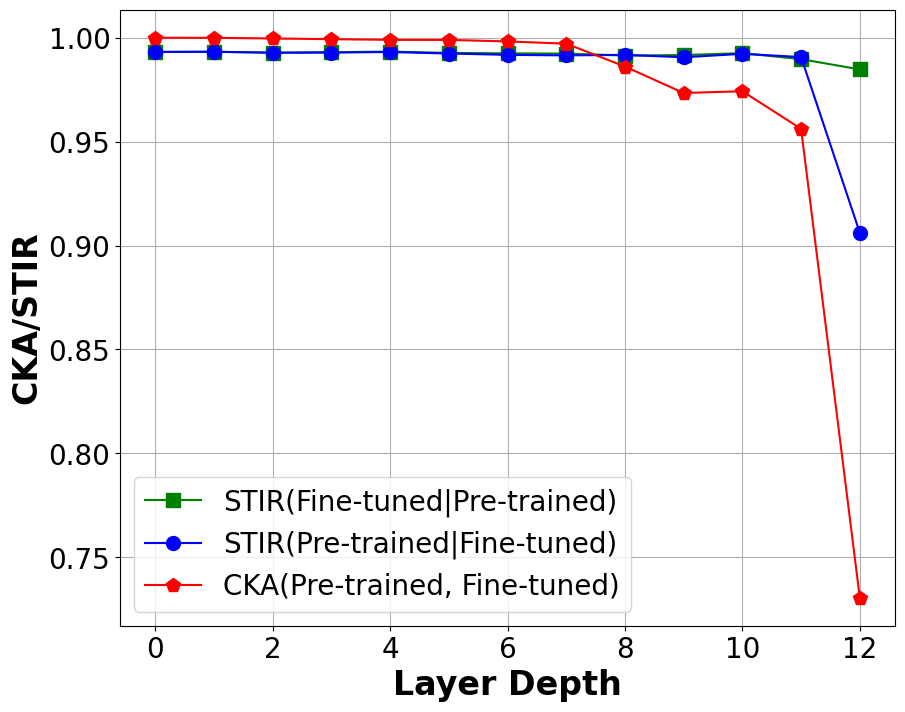

In [20]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(13)
plt.rcParams["figure.figsize"] = [10,8]

series = np.array(STIRm2m1)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='s', markersize=10, color='green')

series = np.array(STIRm1m2)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='o', markersize=10, color='blue')

series = np.array(CKA)
smask = np.isfinite(series)
plt.plot(xs[smask], series[smask], linestyle='-', marker='p', markersize=10, color='red')

plt.legend(['STIR(Fine-tuned|Pre-trained)', 'STIR(Pre-trained|Fine-tuned)', 'CKA(Pre-trained, Fine-tuned)'], fontsize=20)
plt.xlabel('Layer Depth', fontsize = 24, fontweight = 'bold')
plt.ylabel('CKA/STIR', fontsize = 24, fontweight ='bold')

plt.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
#plt.show()
plt.savefig('WNLI CKA STIR.pdf', bbox_inches='tight')
plt.savefig('WNLI CKA STIR.jpg', bbox_inches='tight')

In [19]:
def test(dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask, lm_labels, target_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                        attention_mask=source_mask, 
                                        max_length=10)

            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label=='entailment' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
    return predictions

In [20]:
import pandas as pd
predictions = test(test_dataloader)
filename = '../Original/WNLI.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


In [24]:
def test2(dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = tuple(t.to(device) for t in batch)
            source_ids, source_mask = batch
            outs = model.generate(input_ids=source_ids, 
                                        attention_mask=source_mask, 
                                        max_length=10)

            predicted_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outs]
            binary_labels = [1 if label=='entailment' else 0 for label in predicted_labels]
            predictions.extend(binary_labels)
    return predictions

In [39]:
def getModifiedDataLoader(ts1, ts2):
    inputs = ["wnli sentence1: " + doc1 + " sentence2: "+ doc2 for doc1, doc2 in zip(ts1, ts2)]
    tokenized_inputs = tokenizer(inputs, padding = True, return_tensors="pt")
    source_ids = tokenized_inputs['input_ids']
    source_mask = tokenized_inputs['attention_mask']

    # Create a TensorDataset
    batch_size = 8
    data = TensorDataset(source_ids, source_mask)

    # Create a data loader
    sampler = SequentialSampler(data)
    return DataLoader(data, sampler = sampler, batch_size=batch_size)



test_dataloader = getModifiedDataLoader(test_sentence1, test_sentence2)
predictions = test2(test_dataloader)
filename = '../bias/WNLI.tsv'
result = pd.DataFrame(predictions, columns=['prediction'])
result.insert(0, 'index', range(0, len(result)))
result.to_csv(filename, sep='\t', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.63it/s]
